<a href="https://colab.research.google.com/github/farkoo/Cat-Dog-Classifier/blob/master/final-a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!pwd

/content/drive/MyDrive/IUT-CI-HW3-cat-dog-classifier


In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Prepare train and test data (Data Preprocessing)

In [31]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [32]:
%%bash
git clone "https://github.com/MKasaei00/IUT-CI-HW3-cat-dog-classifier.git"

fatal: destination path 'IUT-CI-HW3-cat-dog-classifier' already exists and is not an empty directory.


In [33]:
%cd IUT-CI-HW3-cat-dog-classifier

/content/drive/MyDrive/IUT-CI-HW3-cat-dog-classifier


In [34]:
%%bash
7z x dataset/test_set.zip -odataset
7z x dataset/training_set.zip -odataset


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
1 file, 3711630 bytes (3625 KiB)

Extracting archive: dataset/test_set.zip
--
Path = dataset/test_set.zip
Type = zip
Physical Size = 3711630
Embedded Stub Size = 4
Total Physical Size = 45654670
Multivolume = +
Volume Index = 2
Volumes = 3


Would you like to replace the existing file:
  Path:     dataset/test_set/cats/cat.4001.jpg
  Size:     46992 bytes (46 KiB)
  Modified: 2019-09-30 02:52:14
with the file from archive:
  Path:     test_set/cats/cat.4001.jpg
  Size:     46992 bytes (46 KiB)
  Modified: 2019-09-30 02:52:14
? (Y)es / (N)o / (A)lways / (S)kip all / A(u)to rename all / (Q)uit? (Y)es / (N)o / (A)lways / (S)kip all / A(u)to rename all / (Q)uit? 



ERROR:
Unexpected end of input stream


In [35]:
import numpy as np
import os
import cv2
from google.colab.patches import cv2_imshow
from keras.utils import np_utils
import matplotlib.pyplot as plt
import tensorflow as tf
import random

In [36]:
def get_image_shapes(dir,count_limit = 10):
  shapes = {}
  for category in os.listdir(dir):
    for file in os.listdir(os.path.join(dir,category)):
      img_path = os.path.join(dir,category,file)
      img = cv2.imread(img_path)
      shape = img.shape
      if shape not in shapes:
        shapes[shape] = 1
      else:
        shapes[shape] = shapes[shape] + 1
      
  return sorted(shapes.items(),key=lambda item : -item[1])[:count_limit]

In [37]:
test_dir = 'dataset/test_set'
training_dir = 'dataset/training_set'

In [38]:
def load_data_from_directory(dir,width,height,classes):
  img_data = []
  img_label = []
  categories = os.listdir(dir)
  for category in categories:
    for file in os.listdir(os.path.join(dir,category)):
      img_path = os.path.join(dir,category,file)
      img = cv2.imread(img_path)
      img = cv2.resize(img,(width,height))
      # cv2_imshow(img)
      img = np.array(img).astype('float32') / 255
      
      img_data.append(img)
      img_label.append(category)

  img_onehot = np_utils.to_categorical([categories.index(label) for label in img_label],classes,dtype=np.ubyte)
  img_data = np.array(img_data)
  img_onehot = np.array(img_onehot)

  zip_list = list(zip(img_data, img_label, img_onehot))
  random.shuffle(zip_list)
  img_data, img_label, img_onehot = zip(*zip_list)
  return img_data , img_label, img_onehot

In [39]:
classes = 2
w = 128
h = 128

In [40]:
train_x , train_label, train_onehot = load_data_from_directory(training_dir,w,h,classes)
test_x , test_label, test_onehot = load_data_from_directory(test_dir,w,h,classes)

In [41]:
test_label2 = []
for i, label in enumerate(test_label):
     test_label2.append(1) if (label == 'dogs') else test_label2.append(0)

In [42]:
train_x = np.asarray(train_x)
train_label = np.asarray(train_label)
train_onehot = np.asarray(train_onehot)

test_x = np.asarray(test_x)
test_label = np.asarray(test_label2)
test_onehot = np.asarray(test_onehot)

In [43]:
!rm -rf cleanData
!mkdir cleanData
np.save('cleanData/train_x.npy',train_x)
np.save('cleanData/train_label.npy',train_label)
np.save('cleanData/train_onehot.npy',train_onehot)

np.save('cleanData/test_x.npy',test_x)
np.save('cleanData/test_label.npy',test_label)
np.save('cleanData/test_onehot.npy',test_onehot)

In [44]:
train_x = np.load('cleanData/train_x.npy')
train_label = np.load('cleanData/train_onehot.npy')

test_x = np.load('cleanData/test_x.npy')
test_label = np.load('cleanData/test_onehot.npy')
test_vec = np.load('cleanData/test_label.npy')

In [45]:
from sklearn.model_selection import train_test_split
train_X, valid_X, train_Label, valid_Label = train_test_split(train_x, train_label, test_size = 0.2, random_state = 13)

# Generate basic Neural Network

In [46]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,LeakyReLU
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.initializers import RandomNormal

# توضیح کلی در مورد عملکرد این تابع

In [47]:
def train_model(config):
  model = Sequential()

  model.add(Flatten(input_shape=(h,w,3)))
  model.add(Dropout(config['in_drop_out']))

  for act ,drop_out, layers in config['layers']:
    for layer in layers:
      model.add(Dense(layer))
      model.add(act())
      model.add(Dropout(drop_out))

  model.compile(
    optimizer=Adam(config['learning_rate']),
    loss=categorical_crossentropy,
    metrics=['accuracy']
  )

  history = model.fit(train_x,train_label,
                    batch_size=config['batch'],
                    epochs = config['epochs'],
                    shuffle=True,
                    validation_data=(valid_X,valid_Label))
  
  
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','validation'],loc='lower right')
  plt.show()

  test_eval = model.evaluate(test_x, test_label, verbose = 0)

  print('Test loss: ', test_eval[0])
  print('Test accuracy: ', test_eval[1])
  print('\n\n')
  predictes_classes = model.predict(test_x)
  predicted_classes = np.argmax(np.round(predictes_classes), axis = 1)

  from sklearn.metrics import classification_report
  target_names = ["Class {}".format(i) for i in range(classes)]
  print(classification_report(test_vec, predicted_classes, target_names = target_names))

  return model

# 1- Initial model, Without any dropout and data augmentation

به کمک دراپ‌اوت بصورت تصادفی تعدادی از نرون ها در هر لایه غیرفعال شده و با استفاده از این راه از بیش‌برازش شدن مدل جلوگیری می‌کنیم.



Epoch 1/100
32/32 [==============================] - 7s 127ms/step - loss: 0.6943 - accuracy: 0.4985 - val_loss: 0.6932 - val_accuracy: 0.4969
Epoch 2/100
32/32 [==============================] - 2s 72ms/step - loss: 0.6933 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.5031
Epoch 3/100
32/32 [==============================] - 2s 73ms/step - loss: 0.6933 - accuracy: 0.5030 - val_loss: 0.6932 - val_accuracy: 0.5031
Epoch 4/100
32/32 [==============================] - 2s 74ms/step - loss: 0.6924 - accuracy: 0.5183 - val_loss: 0.6932 - val_accuracy: 0.5031
Epoch 5/100
32/32 [==============================] - 2s 71ms/step - loss: 0.6906 - accuracy: 0.5277 - val_loss: 0.6925 - val_accuracy: 0.5031
Epoch 6/100
32/32 [==============================] - 2s 68ms/step - loss: 0.6909 - accuracy: 0.5297 - val_loss: 0.6889 - val_accuracy: 0.5225
Epoch 7/100
32/32 [==============================] - 2s 70ms/step - loss: 0.6880 - accuracy: 0.5482 - val_loss: 0.6864 - val_accuracy: 0.5675
Epoch

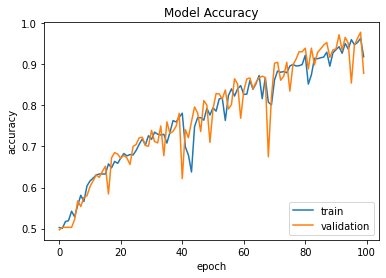

Test loss:  1.0615322589874268
Test accuracy:  0.6209999918937683



              precision    recall  f1-score   support

     Class 0       0.67      0.48      0.56      1000
     Class 1       0.59      0.77      0.67      1000

    accuracy                           0.62      2000
   macro avg       0.63      0.62      0.61      2000
weighted avg       0.63      0.62      0.61      2000



In [48]:
model = train_model({
    'in_drop_out':0,
    'layers' : [
          (lambda : Activation('relu'),0,[2000,1600,800,600,500]+[400]*3+[400]*5+[300,250,200,150,120]), 
          (lambda : Activation('softmax'),0,[2])
    ],
    'learning_rate':3e-4,
    'batch':256,
    'epochs':100
})

# تحلیل مدل اولیه

با مقایسه صحت مدل در زمان آموزش و در زمان تست درمی‌یابیم که مدل دچار پیش‌برازش شده است، چرا که در زمان آموزش صحت مدل تا ۹۶ درصد افزایش یافته و در ۸۸ درصد متوقف شده است اما در زمان تست به ۶۲ درصد کاهش یافته است.

برای حل این مشکل میتوانیم:
- از مدل پیچیده تری استفاده کینم
- در تکنیک منظم سازی دراپ‌اوت بهره بگیریم
- به کمک آگمنتیشن تغییراتی در داده های زمان آموزش ایجاد کنیم

در ادامه بوسیله‌ی دو راه حل آخر سعی شده که عملکرد مدل را بهبود دهیم.

# 2- Train model with Dropout Regularization

Epoch 1/100
32/32 [==============================] - 4s 75ms/step - loss: 0.6979 - accuracy: 0.5043 - val_loss: 0.6951 - val_accuracy: 0.5031
Epoch 2/100
32/32 [==============================] - 2s 68ms/step - loss: 0.6966 - accuracy: 0.5029 - val_loss: 0.6934 - val_accuracy: 0.4969
Epoch 3/100
32/32 [==============================] - 2s 69ms/step - loss: 0.6935 - accuracy: 0.4937 - val_loss: 0.6932 - val_accuracy: 0.5031
Epoch 4/100
32/32 [==============================] - 2s 67ms/step - loss: 0.6938 - accuracy: 0.4987 - val_loss: 0.6934 - val_accuracy: 0.4969
Epoch 5/100
32/32 [==============================] - 2s 68ms/step - loss: 0.6942 - accuracy: 0.4894 - val_loss: 0.6929 - val_accuracy: 0.5200
Epoch 6/100
32/32 [==============================] - 2s 68ms/step - loss: 0.6929 - accuracy: 0.5182 - val_loss: 0.6927 - val_accuracy: 0.4956
Epoch 7/100
32/32 [==============================] - 2s 68ms/step - loss: 0.6915 - accuracy: 0.5270 - val_loss: 0.6849 - val_accuracy: 0.5813
Epoch 

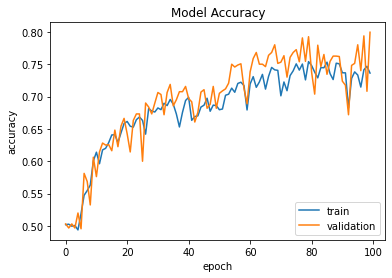

Test loss:  0.7183194756507874
Test accuracy:  0.6259999871253967



              precision    recall  f1-score   support

     Class 0       0.64      0.59      0.61      1000
     Class 1       0.62      0.67      0.64      1000

    accuracy                           0.63      2000
   macro avg       0.63      0.63      0.63      2000
weighted avg       0.63      0.63      0.63      2000



In [51]:
model = train_model({
    'in_drop_out':0,
    'layers' : [
          (lambda : Activation('relu'),0.1,[2000,1600,800,600,500]+[400]*3+[400]*5+[300,250,200,150,120]), 
          (lambda : Activation('softmax'),0,[2])
    ],
    'learning_rate':3e-4,
    'batch':256,
    'epochs':100
})

# تحلیل عملکرد مدل دوم

در این مدل از شبکه ای مشابه با شبکه مدل قبل استفاده کردیم با این تفاوت که با استفاده از دراپ‌اوت ۱۰ درصد در لایه‌های درونی، بصورت تصادفی ۱۰ درصد از نرون ها غیرفعال شده اند تا از بیش‌بردازش مدل جلوگیری شود.


با وجود اینکه صحت مدل در زمان تست نسبت به حالت اول افزایش یافته است، اما همچنان شاهد آورفیت شدن مدل هستیم چرا که صحت مدل در زمان آموزش و تست فاصله‌ی قابل توجهی دارد.


# 3- Add Data Augmentation(Without dropuot)


In [54]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def train_model(config):
  model = Sequential()

  model.add(Flatten(input_shape=(h,w,3)))
  model.add(Dropout(config['in_drop_out']))

  for act ,drop_out, layers in config['layers']:
    for layer in layers:
      model.add(Dense(layer))
      model.add(act())
      model.add(Dropout(drop_out))

  model.compile(
    optimizer=Adam(config['learning_rate']),
    loss=categorical_crossentropy,
    metrics=['accuracy']
  )

  train_datagen = ImageDataGenerator(
        rotation_range=config['aug_rotation'],
        width_shift_range=config['aug_shift_w'],
        height_shift_range=config['aug_shift_h'],
        shear_range=config['aug_shear'],
        zoom_range=config['aug_zoom'],
        horizontal_flip=config['aug_horizontal_flip'],
        fill_mode='nearest'
  )

  train_generator = train_datagen.flow(train_X, train_Label, batch_size = config['batch'])

  validation_datagen = ImageDataGenerator()
  validation_generator = validation_datagen.flow(valid_X,valid_Label,batch_size=256)

  history = model.fit(train_generator,
                      validation_data=validation_generator,
                      epochs = config['epochs'],
                    )
  
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','validation'],loc='lower right')
  plt.show()

  test_eval = model.evaluate(test_x, test_label, verbose = 0)
  print('Test loss: ', test_eval[0])
  print('Test accuracy: ', test_eval[1])
  print('\n\n')
  
  predictes_classes = model.predict(test_x)
  predicted_classes = np.argmax(np.round(predictes_classes), axis = 1)

  from sklearn.metrics import classification_report
  target_names = ["Class {}".format(i) for i in range(classes)]
  print(classification_report(test_vec, predicted_classes, target_names = target_names))

  return model

Epoch 1/100
25/25 [==============================] - 20s 749ms/step - loss: 0.6948 - accuracy: 0.5031 - val_loss: 0.6937 - val_accuracy: 0.4969
Epoch 2/100
25/25 [==============================] - 19s 750ms/step - loss: 0.6942 - accuracy: 0.5003 - val_loss: 0.6930 - val_accuracy: 0.5275
Epoch 3/100
25/25 [==============================] - 19s 766ms/step - loss: 0.6931 - accuracy: 0.5111 - val_loss: 0.6928 - val_accuracy: 0.5350
Epoch 4/100
25/25 [==============================] - 19s 769ms/step - loss: 0.6923 - accuracy: 0.5344 - val_loss: 0.6951 - val_accuracy: 0.5194
Epoch 5/100
25/25 [==============================] - 19s 753ms/step - loss: 0.6880 - accuracy: 0.5560 - val_loss: 0.6831 - val_accuracy: 0.5663
Epoch 6/100
25/25 [==============================] - 18s 738ms/step - loss: 0.6774 - accuracy: 0.5797 - val_loss: 0.6803 - val_accuracy: 0.5750
Epoch 7/100
25/25 [==============================] - 18s 733ms/step - loss: 0.6713 - accuracy: 0.5895 - val_loss: 0.6712 - val_accuracy:

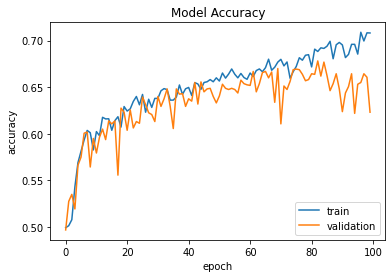

Test loss:  0.6410242319107056
Test accuracy:  0.6345000267028809



              precision    recall  f1-score   support

     Class 0       0.68      0.51      0.58      1000
     Class 1       0.61      0.76      0.68      1000

    accuracy                           0.63      2000
   macro avg       0.64      0.63      0.63      2000
weighted avg       0.64      0.63      0.63      2000



In [55]:
model = train_model({
    'in_drop_out':0,
    'layers' : [
          (lambda : Activation('relu'),0,[2000,1600,800,600,500]+[400]*3+[400]*5+[300,250,200,150,120]), 
          (lambda : Activation('softmax'),0,[2])
    ],
    'learning_rate':3e-4,
    'batch':256,
    'epochs':100,
    'aug_rotation':10,
    'aug_shift_w':0.04,
    'aug_shift_h':0.04,
    'aug_shear':0.04,
    'aug_zoom':0.04,
    'aug_horizontal_flip':True
})

# تحلیل عملکرد مدل سوم

مدل سوم و مدل اولیه ساختار شبکه عصبی یکسانی دارند و هر دو از دراپ‌اوت استفاده نکردند،
 اما مدل سوم برخلاف اولین مدل از دادهای آگمنت شده استفاده کرده است. 

 طبق انتظار، این مدل نسبت به مدل اولیه در زمان تست عملکرد بهتری داشته است و به صحت ۶۳.۵ درصد رسیده است، همچنین در این مدل دیگر شاهد آورفیت شدن مدل نیستیم و بین صحت مدل در زمان آموزش و تست تفاوت چشمگیری دیده نمیشود.

 لازم به ذکر است که مدل سوم از دومین مدل عملکرد بهتری دارد.

# 4- Use data augmentation and dropout regularization

Epoch 1/100
25/25 [==============================] - 20s 749ms/step - loss: 0.6954 - accuracy: 0.4997 - val_loss: 0.6931 - val_accuracy: 0.4981
Epoch 2/100
25/25 [==============================] - 18s 737ms/step - loss: 0.6935 - accuracy: 0.5167 - val_loss: 0.6931 - val_accuracy: 0.4963
Epoch 3/100
25/25 [==============================] - 19s 742ms/step - loss: 0.6931 - accuracy: 0.5045 - val_loss: 0.6931 - val_accuracy: 0.5031
Epoch 4/100
25/25 [==============================] - 19s 739ms/step - loss: 0.6931 - accuracy: 0.5009 - val_loss: 0.6922 - val_accuracy: 0.5556
Epoch 5/100
25/25 [==============================] - 18s 739ms/step - loss: 0.6931 - accuracy: 0.5085 - val_loss: 0.6934 - val_accuracy: 0.5031
Epoch 6/100
25/25 [==============================] - 18s 737ms/step - loss: 0.6935 - accuracy: 0.4987 - val_loss: 0.6919 - val_accuracy: 0.5194
Epoch 7/100
25/25 [==============================] - 18s 737ms/step - loss: 0.6909 - accuracy: 0.5442 - val_loss: 0.6905 - val_accuracy:

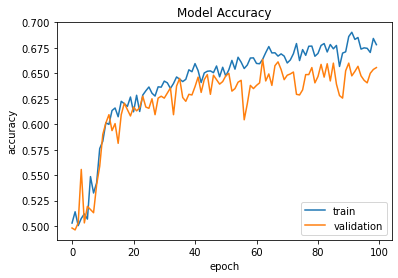

Test loss:  0.616276204586029
Test accuracy:  0.6629999876022339



              precision    recall  f1-score   support

     Class 0       0.67      0.63      0.65      1000
     Class 1       0.65      0.69      0.67      1000

    accuracy                           0.66      2000
   macro avg       0.66      0.66      0.66      2000
weighted avg       0.66      0.66      0.66      2000



In [58]:
model = train_model({
    'in_drop_out':0,
    'layers' : [
          (lambda : Activation('relu'),0.03,[2000,1600,800,600,500]+[400]*3+[400]*5+[300,250,200,150,120]), 
          (lambda : Activation('softmax'),0,[2])
    ],
    'learning_rate':3e-4,
    'batch':256,
    'epochs':100,
    'aug_rotation':10,
    'aug_shift_w':0.04,
    'aug_shift_h':0.04,
    'aug_shear':0.04,
    'aug_zoom':0.04,
    'aug_horizontal_flip':True
})

# تحلیل عملکرد چهارمین مدل

در این قسمت همانند سه مدل قبلی شبکه یکسانی داریم، مشابه مدل دوم از دراپ‌اوت استفاده کرده ایم و مشابه مدل سوم از داده های آگمنت شده برای آموزش مدل استفاده کرده ایم.

در این مدل نیز نسبت به سه مدل قبلی صحت مدل هنگام ارزیابی با داده های تست افزایش یافته است، اگرچه لازم است به این نکته توجه کنیم که درصورت استفاده بیش از انداره از دراپ‌اوت و یا آگمنتیشن مدل آندرفیت شده است و نمیتوانیم به خوبی از قابلیتهای شبکه استفاده کرده و مدل مناسبی آموزش دهیم.

# جمع بندی قسمت الف

در این قسمت ابتدا مدل را با استفاده از یک شبکه عمیق ۱۹ لایه آموزش می‌دهیم.
بعد از ۱۰۰ ایپاک آموزش و ارزیابی مدل با داده های تست دریافتیم که مدل دچار بیش‌برازش شده و عملکرد یکسانی بروی داده های آموزش و تست ندارد.

برای رفع این مشکل از تکنیک منظم سازی دراپ‌اوت و آگمنت کردن داده ها استفاده کردیم و طی مراحل جداگانه رفتار مدل پس از استفاده از این موارد را نشان دادیم و نهایتا توانستیم با داشتن شبکه یکسان از صحت ۶۲ درصد به ۶۶ درصد برسیم.

در هر یک از این مراحل برای مشخص کردن بهترین تنظیم پارامترها موارد گوناگونی بررسی شده است و هم اکنون پارامترهای مدل به گونه ای تنظیم شده اند که از آورفیت شدن یا آندرفیت شدن مدل جلوگیری شود.